#Scripting to get fractional cover
This document is the final version of the scripting needed to get fractional cover for a series of polygons. 
Inputs are a polygon layer, and need a label saying where they are (tbc)


In [ ]:
#Standard libs
import geopandas
import pyogrio
import fiona
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pystac_client
#DEA, odc, dc libs
import odc.aws
import odc.geo.xr
from datacube.utils import masking
import odc.stac
from odc.geo.geom import Geometry, CRS
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb, plot_wo
#change some variables (probably don't need the AWS_NO_SIGN_REQUEST one)
sys.path.insert(1, '../Tools/')
os.environ['AWS_NO_SIGN_REQUEST'] = 'Yes'


In [ ]:
#setup the odc environment (this does the aws part)
def setup_odc_environment():
    catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")
    odc.stac.configure_rio(
        cloud_defaults=True,
        aws={"aws_unsigned": True},
        )
    return catalog
    





In [ ]:
#get polygons file, using gdf
path_to_data = 'C:/Users/willo/OneDrive - UNSW/Desktop/Honours/pct_181.gpkg'
gdf = geopandas.read_file(path_to_data)
#check id if needed gdf["id"]
gdf['id'] = gdf.index
attribute_col = "id"

In [ ]:
gdf

gdf

In [ ]:
#setting up odc and dask environments
catalog = setup_odc_environment()
client = create_local_dask_cluster(return_client=True)

In [ ]:
#adding in collections and start/finish times. Change the end date to a year long period for testing.
start_date = "1986-10-01"
end_date = "1988-03-01"
collections_frac = ["ga_ls_fc_3"]
collections_water = ["ga_ls_wo_3"]
#add water atts because I couldn't find it using odc. Need to work on this using a command in odc.load
water_atts = {
    'data_type' : 'unit8',
    'units': '1',
    'nodata': '1',
    'flags_definition': {'dry': {'bits': [7, 6, 5, 4, 3, 2, 1, 0],
      'values': {'0': True},
      'description': 'No water detected'},
      'wet': {'bits': [7, 6, 5, 4, 3, 2, 1, 0],
      'values': {'128': True},
      'description': 'Clear and Wet'},
      'cloud': {'bits': 6,
      'values': {'0': False, '1': True},
      'description': 'Cloudy'},
      'nodata': {'bits': 0,
      'values': {'0': False, '1': True},
      'description': 'No data'},
      'high_slope': {'bits': 4,
      'values': {'0': False, '1': True},
      'description': 'High slope'},
      'cloud_shadow': {'bits': 5,
      'values': {'0': False, '1': True},
      'description': 'Cloud shadow'},
      'noncontiguous': {'bits': 1,
      'values': {'0': False, '1': True},
      'description': 'At least one EO band is missing or saturated'},
      'terrain_shadow': {'bits': 3,
      'values': {'0': False, '1': True},
      'description': 'Terrain shadow'},
      'water_observed': {'bits': 7,
      'values': {'0': False, '1': True},
      'description': 'Classified as water by the decision tree'},
      'low_solar_angle': {'bits': 2,
      'values': {'0': False, '1': True},
      'description': 'Low solar incidence angle'}},
    'crs': 'EPSG:32655',
    'grid_mapping': 'spatial_ref'}


In [ ]:
results_dask = {}
#itterates through each row in gdf
for index, row in gdf.iterrows():
    #not needed, just updates
    print(f'Feature: {index + 1}/{len(gdf)}')
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    print(geom)
    bbox = row.geometry.bounds
    #The layer column holds information about the land ownership
    location = row["layer"]
    #do an initial catalog search to see what items to query using odc.load
    query_frac = catalog.search(
        bbox=bbox,
        collections=collections_frac,
        datetime=f"{start_date}/{end_date}"
    )
    items_frac = list(query_frac.items())
    #just another update, not needed
    print(f"Found: {len(items_frac):d} datasets")
    #find (??) the data using odc.load based on the queried items. Note this uses Dask which is significantly quicker
    #than loading locally. This is because it loads the data in chunks and only loads the data when needed
    # note this does not actually load anything. Dask performs all operations lazily, so it only loads the data when
    #it is needed. This is why we need to use .load() to actually load the data
    frac = odc.stac.load(
        items_frac,
        resolution=30,
        groupby="solar_day",
        geopolygon=geom,
        chunks={"time": 1, "x": 2048, "y": 2048}
    )
    #same as above, but need the water layer for cloud and water masking
    query_water = catalog.search(
        bbox=bbox,
        collections=collections_water,
        datetime=f"{start_date}/{end_date}"
    )
    items_water = list(query_water.items())
    print(f"Found: {len(items_water):d} datasets")
    wo = odc.stac.load(
        items=items_water,
        resolution=30,
        groupby="solar_day",
        geopolygon=geom,
        chunks={"time": 1, "x": 2048, "y": 2048}
    )
    #now for the operations (remeber these are lazy)
    #add water attributes to the water layer. See above notes on needing to work on this
    print("1")
    wo.water.attrs =  water_atts
    #converting water layers to uint8. Needed for masking. Can't do this on whole dataarray, breaks it
    print("2")
    wo['water'] = wo['water'].astype(np.uint8)
    #Make mask layer using the DEA provided function. Shoudl make own at some point but this works well
    print("3")
    wo_mask = masking.make_mask(wo.water, dry=True)
    #mask the fractional cover layer with the mask layer
    print("4")
    fc_masked = frac.where(wo_mask)
    #calculate the percentage of no data in the masked layer. If it is greater than 50% then we remove the data
    print("5")
    percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])
    print("6")
    fc_masked = fc_masked.sel(time=percent_nodata < 0.5)
    #calculate the mean of the fractional cover layer through time (it gives mean values for each polygon at each 
    #time step)
    print("7")
    fc_through_time = fc_masked[['pv', 'npv', 'bs', 'ue']].mean(dim=['x', 'y'])

    #add the data to the results_dask dictionary
    print("8")
    attribute_val = row[attribute_col]
    #add location (ie ownership) to the data as a coordinate. Same with the id. this makes for easier processing
    #as a pandas dataframe later on, I'm still not comfortable with xarray
    print("9")
    print(attribute_val)
    print(location)
    fc_through_time = fc_through_time.assign_coords(location=location,
                                                    id = attribute_val)
    #finally load the data using dask
    print("10")
    results_dask[attribute_val] = fc_through_time.load()

    

print("Done!")


In [ ]:
results_dask

In [ ]:
results_no_dask = {}
#itterates through each row in gdf
for index, row in gdf.iterrows():
    #not needed, just updates
    print(f'Feature: {index + 1}/{len(gdf)}')
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    bbox = row.geometry.bounds
    #The layer column holds information about the land ownership
    location = row["layer"]
    #do an initial catalog search to see what items to query using odc.load
    query_frac = catalog.search(
        bbox=bbox,
        collections=collections_frac,
        datetime=f"{start_date}/{end_date}"
    )
    items_frac = list(query_frac.items())
    
    #just another update, not needed
    print(f"Found: {len(items_frac):d} datasets")
    #find (??) the data using odc.load based on the queried items. Note this uses Dask which is significantly quicker
    #than loading locally. This is because it loads the data in chunks and only loads the data when needed
    # note this does not actually load anything. Dask performs all operations lazily, so it only loads the data when
    #it is needed. This is why we need to use .load() to actually load the data
    frac = odc.stac.load(
        items_frac,
        resolution=30,
        groupby="solar_day",
        geopolygon=geom
    )
    #same as above, but need the water layer for cloud and water masking
    query_water = catalog.search(
        bbox=bbox,
        collections=collections_water,
        datetime=f"{start_date}/{end_date}"
    )
    items_water = list(query_water.items())
    print(f"Found: {len(items_water):d} datasets")
    wo = odc.stac.load(
        items=items_water,
        resolution=30,
        groupby="solar_day",
        geopolygon=geom
    )
    #now for the operations (remeber these are lazy)
    #add water attributes to the water layer. See above notes on needing to work on this
    print("1")
    wo.water.attrs =  water_atts
    #converting water layers to uint8. Needed for masking. Can't do this on whole dataarray, breaks it
    print("2")
    wo['water'] = wo['water'].astype(np.uint8)
    #Make mask layer using the DEA provided function. Shoudl make own at some point but this works well
    print("3")
    wo_mask = masking.make_mask(wo.water, dry=True)
    #mask the fractional cover layer with the mask layer
    print("4")
    fc_masked = frac.where(wo_mask)
    #calculate the percentage of no data in the masked layer. If it is greater than 50% then we remove the data
    print("5")
    #percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])
    #fc_masked = fc_masked.sel(time=percent_nodata < 0.5)
    #calculate the mean of the fractional cover layer through time (it gives mean values for each polygon at each 
    #time step)
    print("6")
    #fc_through_time = fc_masked[['pv', 'npv', 'bs', 'ue']].mean(dim=['x', 'y'])

    #add the data to the results_dask dictionary
    print("7")
    attribute_val = row[attribute_col]
    #add location (ie ownership) to the data as a coordinate. Same with the id. this makes for easier processing
    #as a pandas dataframe later on, I'm still not comfortable with xarray
    print("8")
    fc_masked = fc_masked.assign_coords(location=location,
                                                    id = attribute_val)
    #finally load the data using dask
    print("9")
    results_no_dask[attribute_val] = fc_masked

    

print("Done!")


In [28]:


df = pd.DataFrame(columns=['pv', 'npv', 'bs', 'ue', 'location', 'id'])

for item in results_dask:
    temp_df = results_dask[item].to_pandas().reset_index()
    print(temp_df)
    df = pd.concat([df, temp_df])



                        time         pv        npv         bs         ue  \
0 1987-05-27 23:25:36.229081  37.332237  52.059574   9.562865  14.373903   
1 1987-07-30 23:27:01.946050  16.488947  61.057915  21.324492  14.500000   
2 1987-08-31 23:27:57.178000  28.598032  48.678345  21.462204  18.889763   
3 1987-12-05 23:29:51.520075  62.376762  27.834448   8.396437  17.206013   
4 1987-12-21 23:30:05.947094  67.220833  26.944241   4.381145  16.729641   
5 1988-01-06 23:30:21.981006  65.118774  27.493176   5.974548  18.004427   
6 1988-02-07 23:30:58.127000  57.881294  33.259094   7.435869  16.905916   
7 1988-02-23 23:31:11.379075  54.136879  34.477432   9.921101  15.617248   

   spatial_ref      location  id  
0        32655  priv_non_ram   0  
1        32655  priv_non_ram   0  
2        32655  priv_non_ram   0  
3        32655  priv_non_ram   0  
4        32655  priv_non_ram   0  
5        32655  priv_non_ram   0  
6        32655  priv_non_ram   0  
7        32655  priv_non_ram   0  


C:\Users\willo\AppData\Local\Temp\ipykernel_19936\3749623418.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df])


                        time         pv        npv         bs         ue  \
0 1987-05-27 23:25:36.229081  40.471073  51.528927   6.818182  13.553719   
1 1987-07-30 23:27:01.946050   8.900826  80.247932   9.876033  15.132232   
2 1987-08-31 23:27:57.178000  11.504132  77.454544  10.024794  13.818182   
3 1987-12-05 23:29:51.520075  71.966942  21.884298   4.595041  17.008265   
4 1987-12-21 23:30:05.947094  76.925621  19.388430   2.074380  16.289257   
5 1988-01-06 23:30:21.981006  77.272728  19.487604   1.760331  17.545454   
6 1988-02-07 23:30:58.127000  73.801651  22.842976   1.867769  16.586777   
7 1988-02-23 23:31:11.379075  73.289253  22.479340   2.710744  15.388430   

   spatial_ref location  id  
0        32655     MMNR  62  
1        32655     MMNR  62  
2        32655     MMNR  62  
3        32655     MMNR  62  
4        32655     MMNR  62  
5        32655     MMNR  62  
6        32655     MMNR  62  
7        32655     MMNR  62  
                        time        pv       

In [ ]:
test = df.groupby(['time', 'location'], as_index=False).agg({'pv': 'mean', 'npv': 'mean', 'bs': 'mean'})
#test2 = df_2.groupby(['time', 'location'], as_index=False).agg({'pv': 'mean', 'npv': 'mean', 'bs': 'mean'})

test


In [29]:
df

,pv,npv,bs,ue,location,id,time,spatial_ref
0,37.332237,52.059574,9.562865,14.373903,priv_non_ram,0,1987-05-27 23:25:36.229081,32655.0
1,16.488947,61.057915,21.324492,14.500000,priv_non_ram,0,1987-07-30 23:27:01.946050,32655.0
2,28.598032,48.678345,21.462204,18.889763,priv_non_ram,0,1987-08-31 23:27:57.178000,32655.0
3,62.376762,27.834448,8.396437,17.206013,priv_non_ram,0,1987-12-05 23:29:51.520075,32655.0
4,67.220833,26.944241,4.381145,16.729641,priv_non_ram,0,1987-12-21 23:30:05.947094,32655.0
...,...,...,...,...,...,...,...,...
4,53.000000,35.125000,10.437500,17.500000,priv_non_ram,129,1987-12-05 23:29:51.520075,32655.0
5,59.312500,36.500000,2.937500,16.312500,priv_non_ram,129,1987-12-21 23:30:05.947094,32655.0
6,58.875000,35.375000,4.312500,16.937500,priv_non_ram,129,1988-01-06 23:30:21.981006,32655.0
7,55.687500,37.437500,5.687500,17.625000,priv_non_ram,129,1988-02-07 23:30:58.127000,32655.0


In [22]:
df

,pv,npv,bs,location,id,time,ue,spatial_ref
0,37.332237,52.059574,9.562865,priv_non_ram,0,1987-05-27 23:25:36.229081,14.373903,32655.0
1,16.488947,61.057915,21.324492,priv_non_ram,0,1987-07-30 23:27:01.946050,14.500000,32655.0
2,28.598032,48.678345,21.462204,priv_non_ram,0,1987-08-31 23:27:57.178000,18.889763,32655.0
3,62.376762,27.834448,8.396437,priv_non_ram,0,1987-12-05 23:29:51.520075,17.206013,32655.0
4,67.220833,26.944241,4.381145,priv_non_ram,0,1987-12-21 23:30:05.947094,16.729641,32655.0
...,...,...,...,...,...,...,...,...
4,53.000000,35.125000,10.437500,priv_non_ram,129,1987-12-05 23:29:51.520075,17.500000,32655.0
5,59.312500,36.500000,2.937500,priv_non_ram,129,1987-12-21 23:30:05.947094,16.312500,32655.0
6,58.875000,35.375000,4.312500,priv_non_ram,129,1988-01-06 23:30:21.981006,16.937500,32655.0
7,55.687500,37.437500,5.687500,priv_non_ram,129,1988-02-07 23:30:58.127000,17.625000,32655.0


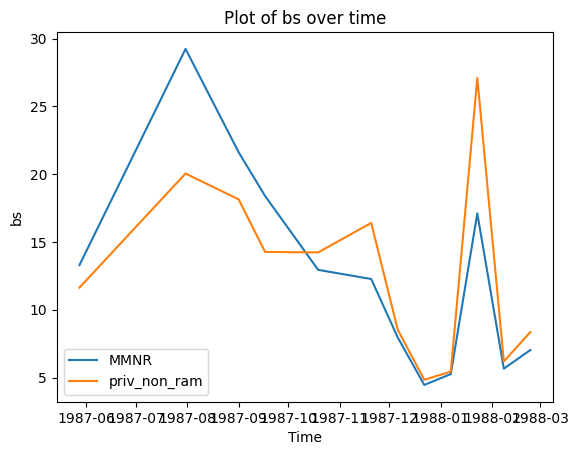

In [30]:

# Group the data by location
groups = test.groupby('location')

# Plot each group separately with different colors
for name, group in groups:
    plt.plot(group['time'], group['bs'], label=name)

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('bs')

# Set the title of the plot
plt.title('Plot of bs over time')

# Add a legend
plt.legend()

# Show the plot
plt.show()

import plotly.express as px

fig = px.line(df, x='time', y='bs', color='location')
fig.update_layout(
    title='Plot of bs over time',
    xaxis_title='Time',
    yaxis_title='bs',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)
fig.show()

In [ ]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time




